In [1]:
from pediatricIQphantoms.make_phantoms import mirt_sim
import matplotlib.pyplot as plt

In [2]:
mirt_sim?

Signature:
mirt_sim(
    phantom='CCT189',
    patient_diameter=200,
    reference_diameter=200,
    reference_fov=340,
    I0=300000.0,
    nb=900,
    na=580,
    ds=1,
    sid=595,
    sdd=1085.6,
    offset_s=1.25,
    down=1,
    has_bowtie=False,
    add_noise=True,
    aec_on=True,
    nx=512,
    fov=340,
    fbp_kernel='hanning,2.05',
    nsims=1,
    relative_lesion_diameter=False,
)
Docstring: Python wrapper for calling Michigan Image Reconstruction Toolbox (MIRT) Octave function 
File:      ~/Dev/pediatricIQphantoms/src/pediatricIQphantoms/make_phantoms.py
Type:      function

In [14]:
res = mirt_sim('CTP404')

/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms
The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 10"
ellipse_im: 5 of 10 0.0
ellipse_im: 9 of 10 0.0
ct_sim, simulation: [1/1]
fbp2_back_fan: 103 of 580 0.0
fbp2_back_fan: 206 of 580 0.0
fbp2_back_fan: 309 of 580 0.1
fbp2_back_fan: 411 of 580 0.1
fbp2_back_fan: 514 of 580 0.1


In [15]:
res.keys()

dict_keys(['recon', 'ground_truth', 'sinogram_noiseless'])

In [16]:
res.recon.shape

(1, 512, 512)

In [17]:
def ctshow(img, win=None, lvl=None):
    if img.ndim > 2: img = img[0]
    if (win is None) or (lvl is None):
        vmin = None
        vmax = None
    else:
        vmin = lvl-win/2
        vmax = lvl+win/2
    plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()

Text(0.5, 1.0, 'Ground Truth')

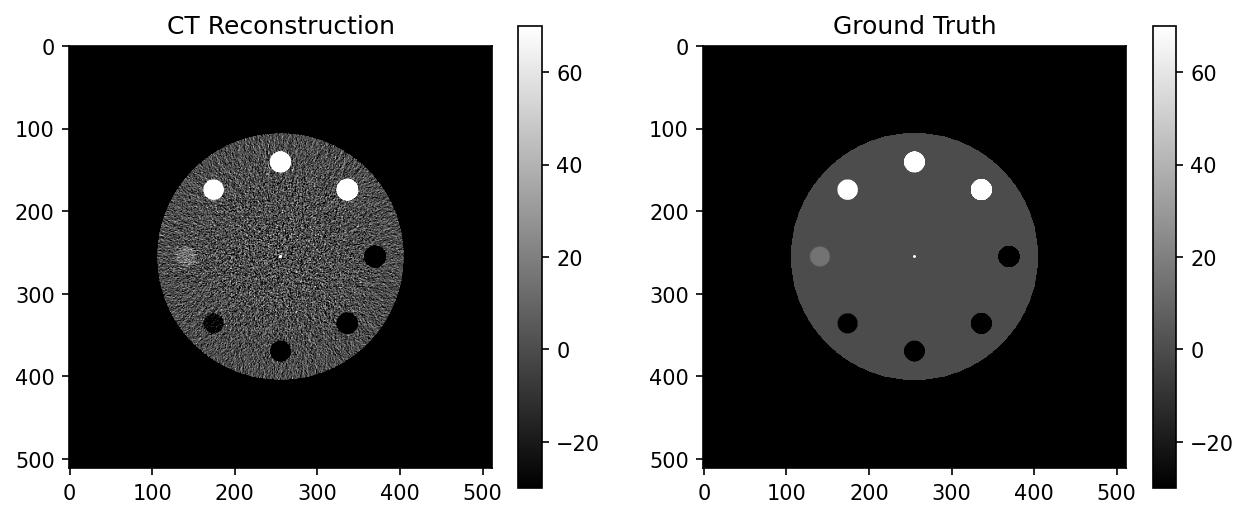

In [44]:
plt.figure(figsize=(10,4), dpi=150)
plt.subplot(1,2,1)
win, lvl = 100, 20
ctshow(res.recon, win, lvl)
plt.title('CT Reconstruction')
plt.subplot(1,2,2)
ctshow(res.ground_truth, win, lvl)
plt.title('Ground Truth')

Text(0, 0.5, 'detector index')

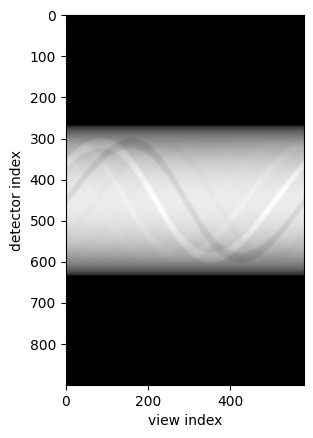

In [45]:
import numpy as np
plt.imshow(-np.log(res.sinogram_noiseless), cmap='gray')
plt.xlabel('view index')
plt.ylabel('detector index')

## Different Phantoms

In [47]:
ctp404 = mirt_sim('CTP404')
cct189 = mirt_sim('CCT189', I0=3e7) # <-- higher dose to show low contrast lesions
uniform = mirt_sim('uniform')

/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms
The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 10"
ellipse_im: 5 of 10 0.0
ellipse_im: 9 of 10 0.0
ct_sim, simulation: [1/1]
fbp2_back_fan: 99 of 580 0.0
fbp2_back_fan: 201 of 580 0.0
fbp2_back_fan: 304 of 580 0.1
fbp2_back_fan: 408 of 580 0.1
fbp2_back_fan: 509 of 580 0.1
/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms
The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you inst

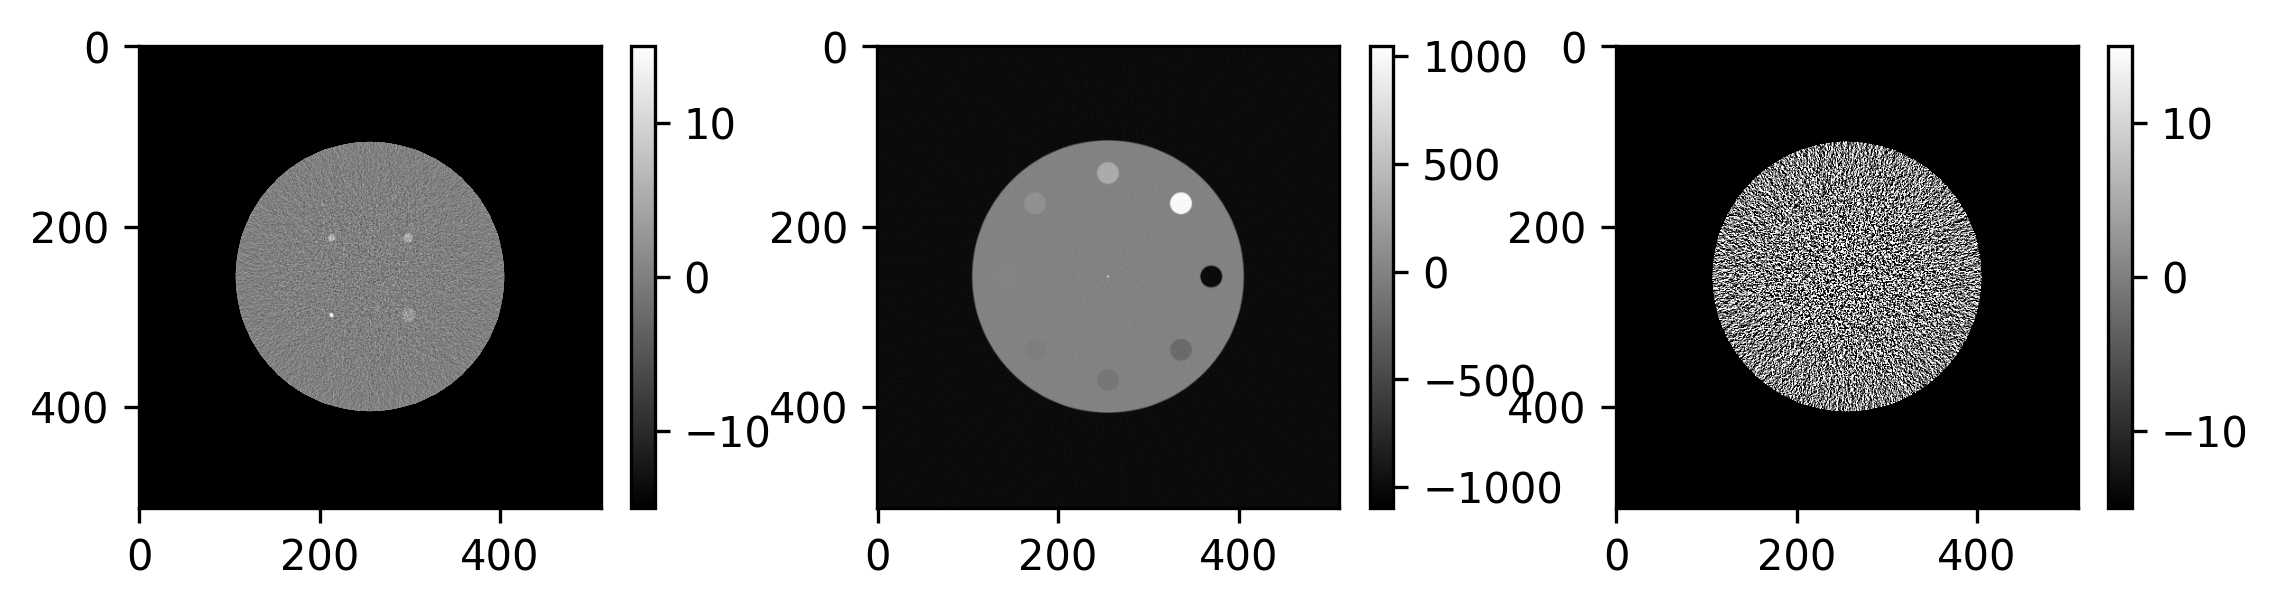

In [48]:
plt.figure(figsize=(9, 2), dpi=300)

plt.subplot(1,3,1)
ctshow(cct189.recon, 30, 0)

plt.subplot(1,3,2)
ctshow(ctp404.recon)

plt.subplot(1,3,3)
ctshow(uniform.recon, 30, 0)
plt.show()

## Different Dose Levels

In [49]:
doses = [3e5, 3e6, 3e7]
res_list = [mirt_sim('CCT189', I0=I0) for I0 in doses]

/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms
The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 10"
ellipse_im: 5 of 5 0.0
ct_sim, simulation: [1/1]
fbp2_back_fan: 100 of 580 0.0
fbp2_back_fan: 203 of 580 0.0
fbp2_back_fan: 305 of 580 0.1
fbp2_back_fan: 403 of 580 0.1
fbp2_back_fan: 506 of 580 0.1
/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms
The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "

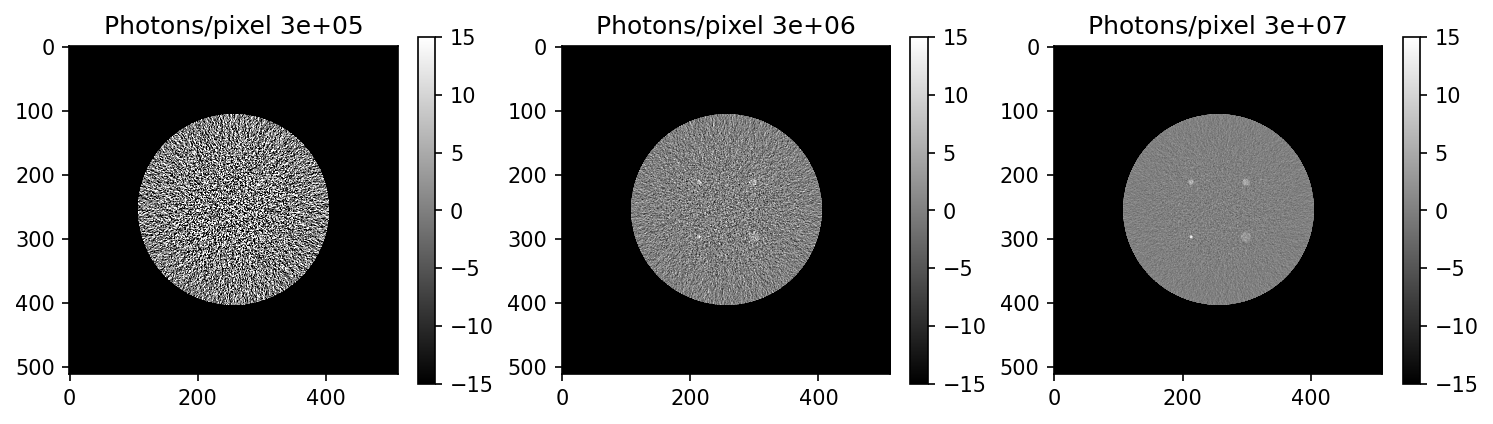

In [65]:
nres = len(res_list)
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    plt.subplot(1, nres, idx+1)
    ctshow(res.recon, 30, 0)
    plt.title(f'Photons/pixel {doses[idx]:1.1g}')

## Recon Type

In [72]:
cutoff_freq = [0.5, 0.85, 2.05]

res_list = [mirt_sim('CCT189', I0=1e6, fbp_kernel=f'hanning,{freq:1.2f}') for freq in cutoff_freq]    

/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms
The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 10"
ellipse_im: 5 of 5 0.0
ct_sim, simulation: [1/1]
fbp2_back_fan: 100 of 580 0.0
fbp2_back_fan: 201 of 580 0.0
fbp2_back_fan: 304 of 580 0.1
fbp2_back_fan: 409 of 580 0.1
fbp2_back_fan: 513 of 580 0.1
/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms
The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "

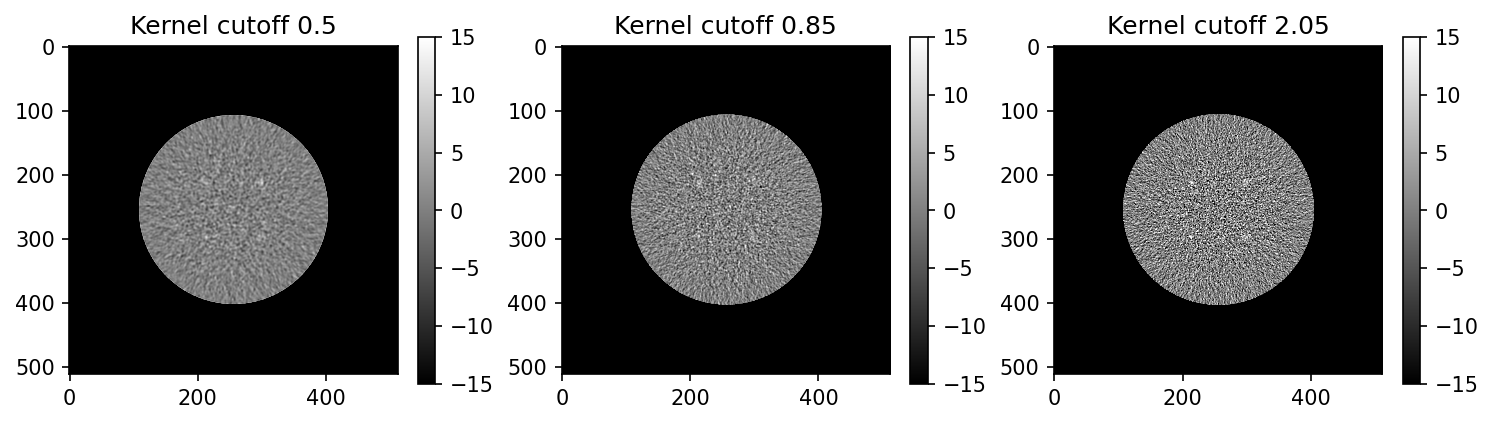

In [73]:
nres = len(res_list)
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    plt.subplot(1, nres, idx+1)
    ctshow(res.recon, 30, 0)
    plt.title(f'Kernel cutoff {cutoff_freq[idx]}')

## Phantom Size and FOV
(most important piece)

In [74]:
phantom_diameters = [112, 185, 292]

res_list = [mirt_sim('CCT189', I0=1e6, patient_diameter=d) for d in phantom_diameters]   

/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms
The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 10"
ellipse_im: 5 of 5 0.0
ct_sim, simulation: [1/1]
fbp2_back_fan: 106 of 580 0.0
fbp2_back_fan: 209 of 580 0.0
fbp2_back_fan: 314 of 580 0.1
fbp2_back_fan: 419 of 580 0.1
fbp2_back_fan: 520 of 580 0.1
/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms
The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "

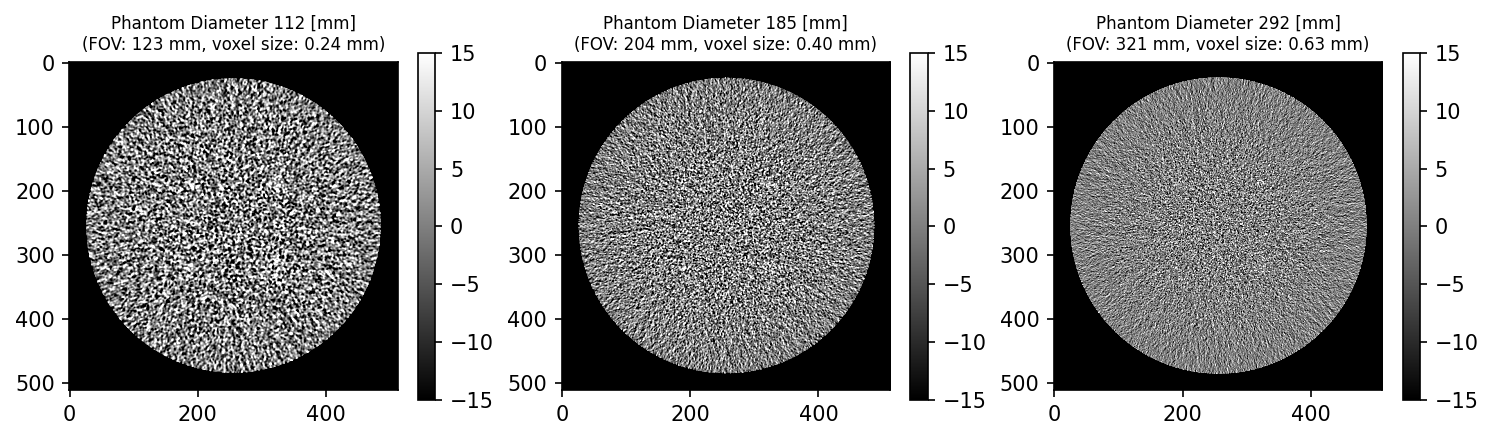

In [87]:
fov = np.array(phantom_diameters)*1.1 # in mm
dx = fov/res.recon.shape[-1]

nres = len(res_list)
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    plt.subplot(1, nres, idx+1)
    ctshow(res.recon, 30, 0)
    plt.title(f'Phantom Diameter {phantom_diameters[idx]} [mm]\n(FOV: {fov[idx]:2.0f} mm, voxel size: {dx[idx]:2.2f} mm)', fontsize=8)

By default when FOV is not specified, it defaults to a body fitting 1.1x the phantom diameter. Note how FOV changes the relative pixel size

/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms
The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon/Dev/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 10"
ct_sim, simulation: [1/1]
fbp2_back_fan: 108 of 580 0.0
fbp2_back_fan: 218 of 580 0.0
fbp2_back_fan: 325 of 580 0.1
fbp2_back_fan: 433 of 580 0.1
fbp2_back_fan: 540 of 580 0.1


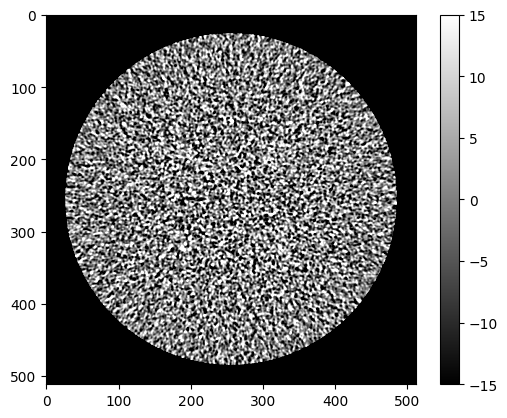

In [90]:
res = mirt_sim('CCT189', I0=1e6, patient_diameter=112, fov=500)
ctshow(res.recon, 30, 0)

*Seems FOV not changing anything need to list as a fix*